In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import meta_variables as mv
import constants_and_functions as cf
import manipulate_text as mt
from scipy.interpolate import interp2d

In [19]:
base_path = os.getcwd().split('scripts')[0]
sync_path = base_path + 'synchrotron_emission/'

In [33]:
mx_min = 6
mx_max = 500
num_mx = 20
D0_min = 3e28
D0_max = 3e28
num_D0 = 1
mx_ar = np.array([38.6])
print(mx_ar)
D0_ar = np.array([3e27, 3e28, 3e29])
#D0_ar = np.logspace(np.log10(D0_min), np.log10(D0_max), num_D0)
runs = mt.find_results(2, mx=mx_ar, D0=D0_ar)

[38.6]
this_path = /het/p4/mjw283/eventgen_wd/Secondary_radiation/scripts/manipulate_text.py


In [34]:
print(runs)

[{'file_name': '0009_synchrotron_emission_info.txt', 'mx': 38.6, 'D0': 3e+28, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigma_v': 2.2e-26, 'DA': 780.0, 'nrho': 60, 'nnu': 70, 'rho_range': [0.1, 35.0], 'nu_range': [100000.0, 1e+24]}, {'file_name': '0038_synchrotron_emission_info.txt', 'mx': 38.6, 'D0': 3e+27, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigma_v': 2.2e-26, 'DA': 780.0, 'nrho': 60, 'nnu': 70, 'rho_range': [0.1, 35.0], 'nu_range': [100000.0, 1e+24]}, {'file_name': '0039_synchrotron_emission_info.txt', 'mx': 38.6, 'D0': 3e+29, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigma_v': 2.2e-26, 'DA': 780.0, 'nrho': 60, 'nnu': 70, 'rho_range': [0.1, 35.0], 'nu_range': [100000.0, 1e+24]}]


In [35]:
inds = []
for run in runs:
    this_D0 = run['D0']
    this_ind = np.where(D0_ar==this_D0)[0][0]
    inds.append(this_ind)
p = np.argsort(inds)
file_names = [runs[arg]['file_name'].split('_info')[0] + '.npy' for arg in p]
print(file_names)

['0038_synchrotron_emission.npy', '0009_synchrotron_emission.npy', '0039_synchrotron_emission.npy']


In [36]:
DA = runs[0]['DA']
nrho = runs[0]['nrho']
nnu = runs[0]['nnu']
rho_range = runs[0]['rho_range']
nu_range = runs[0]['nu_range']
nu_v = np.logspace(np.log10(nu_range[0]), np.log10(nu_range[1]), nnu)
rho_v = np.linspace(rho_range[0], rho_range[1], nrho)
theta_v = np.arcsin(rho_v/np.sqrt(rho_v**2+DA**2))
thetatheta, nunu = np.meshgrid(theta_v, nu_v)
nu_set = np.logspace(8, 11, 4)
f_plt = np.zeros((len(D0_ar)*len(nu_set), nrho))
row = 0
for i in range(len(D0_ar)):
    nudSdnudth = np.load(sync_path + file_names[i])
    dS_dnudOmega = ((10**26/nunu)*nudSdnudth/(2*np.pi*np.sin(thetatheta))).astype(np.float64) #mJy/Sr
    max_nonzero = dS_dnudOmega.shape[0]
    inds = np.where(dS_dnudOmega==0)[0]
    if len(inds)>0:
        max_nonzero = np.min(inds)
    flux_interp = interp2d(thetatheta[0], nunu[:max_nonzero, 0], dS_dnudOmega[:max_nonzero, :])
    
    for nu in nu_set:
        f_plt[row] = flux_interp(theta_v, nu)
        row +=1

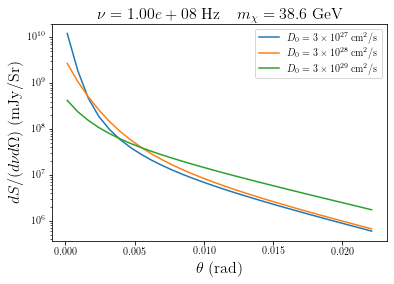

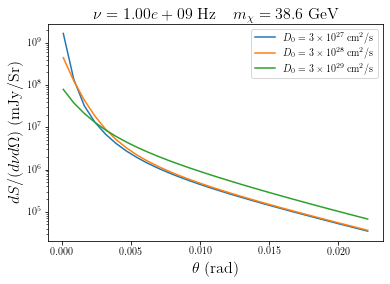

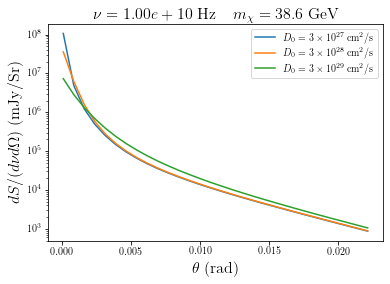

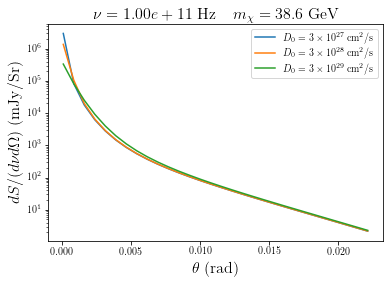

In [39]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
tex_str_D0 = ['3 10^{27}', '3 10^{28}', '3 10^{29}']

for i in range(len(nu_set)):
    fig = plt.figure()
    for j in range(len(D0_ar)):
        plt.plot(theta_v[:30], f_plt[i + j*len(nu_set), :30], label=r'$D_0 = ' + tex_str_D0[j][0]+ r'\times' + tex_str_D0[j][1:]+ r'\; \mathrm{cm^2/s}$')
    plt.title(r'$\nu = '+ '{:.2e}'.format(nu_set[i]) + r' \; \mathrm{Hz} \;\;\;\; m_\chi = ' + str(mx_ar[0]) + ' \;\mathrm{GeV}$', size=16)
    plt.xlabel(r'$\theta \; \mathrm{(rad)}$', size=16)
    plt.ylabel(r'$dS/(d\nu d\Omega) \; \rm{(mJy/Sr)}$', size=16)
    plt.yscale('log')
    plt.legend()
    plt.savefig(base_path + 'figs/' + 'synchrotron_mx_' + str(mx_ar[0]) +'_nu_' +'{:.2e}'.format(nu_set[i])+'_compare_D0.pdf')